<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson7/GB_PyTorch_hw_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

In [1]:
!pip install stop-words pymorphy2 -q

     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 8.2 MB 10.8 MB/s 


In [2]:
import torch
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
# from pymorphy2 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import islice
from nltk.probability import FreqDist
import nltk
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [3]:
! mkdir ~/.kaggle
from google.colab import files

files.upload()

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech
! unzip -q '/content/twitter-sentiment-analysis-hatred-speech.zip'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Saving kaggle.json to kaggle.json
  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 203MB/s]


device(type='cuda', index=0)

In [4]:
df_train = pd.read_csv('/content/train.csv')
print(df_train.shape)
df_train.head()

(31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
# df_test = pd.read_csv('/content/test.csv')
# print(df_test.shape)
# df_test.head()

In [5]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [6]:
random_state = 42

max_words = 1500
max_len = 15
num_classes = 1

# Training
epochs = 10
batch_size = 512
embedding_dim = 256
out_channel = 256

Несбалансированность классов будем исправлять за счёт стратификации.

In [7]:
X_train, X_val = train_test_split(df_train, 
                                  test_size=0.2, 
                                  random_state=random_state, 
                                  stratify=df_train['label'])

X_train.shape, X_val.shape

((25569, 3), (6393, 3))

## Предобработка

In [8]:
sw = set(get_stop_words("en"))
sw.add('@user')
sw.add('user')
sw

{'@user',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'sh

In [9]:
puncts = set(punctuation)
# puncts

In [10]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
def preprocess_text(txt):
    txt = str(txt)
    # уберем нечитаемые символы типа  ð\x9f¤\x97
    txt = "".join([c for c in txt if ord(c) < 128])
    txt = ''.join(char for char in txt if char not in puncts) # очистка от пунктуации
    txt = txt.lower()
    # преобразуем отрицания
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("no\s", "no", txt)
    
    txt = [lemmatizer.lemmatize(word) for word in txt.split()] # лемматизация
    txt = [word for word in txt if word not in sw]
    return ' '.join(txt)

In [12]:
from tqdm import tqdm 
tqdm.pandas()

X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_val['tweet'] = X_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 6393/6393 [00:00<00:00, 14653.30it/s]


Подготовим общий корпус текста:

In [13]:
train_corpus = " ".join(X_train["tweet"])
train_corpus = train_corpus.lower()
# train_corpus

Сделаем токенизацию:

In [14]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['first',
 'order',
 'something',
 'black',
 'amp',
 'sexy',
 's',
 'collection',
 'cantwait',
 'although']

In [15]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [16]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1499

In [17]:
# Посмотрим на топ 10 слов
tokens_filtered_top[:10]

['love', 'day', 'happy', 'u', 'amp', 'just', 'will', 'life', 'time', 'im']

In [18]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [19]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [20]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_val['tweet']])

x_train.shape, x_val.shape

CPU times: user 2.84 s, sys: 10.7 ms, total: 2.85 s
Wall time: 2.86 s


((25569, 15), (6393, 15))

In [21]:
X_train['tweet'].iloc[0]

'first order something black amp sexy s collection cantwait'

In [22]:
x_train[0]

array([  55,  482,  231,  127,    5,  298,  301, 1130,  586,    0,    0,
          0,    0,    0,    0])

## LSTM

Собираем сеть.

In [96]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, drop_prob=0.1, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=drop_prob)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [97]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [98]:
train_dataset = DataWrapper(x_train, X_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, X_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [99]:
model_LTSM = LSTMFixedLen(vocab_size=max_words, embedding_dim=embedding_dim)

print(model_LTSM)
print("Parameters:", sum([param.nelement() for param in model_LTSM.parameters()]))

# компиляция модели
optimizer = torch.optim.Adam(model_LTSM.parameters(), lr=1e-3)
criterion = nn.BCELoss()

LSTMFixedLen(
  (embeddings): Embedding(1500, 256, padding_idx=0)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Parameters: 713857


Создадим функцию для проверки

In [100]:
def train_nn(th=0.5, vocab_size=1500, embedding_dim=128, learning_rate=1e-3, epochs=epochs, batch_size=batch_size, visual=False):

  random_state = 42

  # max_words = 1500
  max_len = 15
  num_classes = 1

  # Training
  epochs = epochs
  batch_size = batch_size
  # embedding_dim = 256
  # out_channel = 256

  model_LTSM = LSTMFixedLen(vocab_size, embedding_dim)
  optimizer = torch.optim.Adam(model_LTSM.parameters(), lr=learning_rate)
  criterion = nn.BCELoss()

  print("Parameters of model:", sum([param.nelement() for param in model_LTSM.parameters()]))

  model_LTSM = model_LTSM.to(device)
  model_LTSM.train()
  th = th

  train_loss_history = []
  test_loss_history = []
  train_f1_history = []
  test_f1_history = []

  for epoch in range(epochs):
  
    running_items, running_right = 0.0, 0.0
    tp, fp, tn, fn = 0, 0, 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_LTSM(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

        tp += ((labels == 1) & (pred_labels == 1)).sum().item()
        tn += ((labels == 0) & (pred_labels == 0)).sum().item()
        fp += ((labels == 0) & (pred_labels == 1)).sum().item()
        fn += ((labels == 1) & (pred_labels == 0)).sum().item()

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    # выводим статистику о процессе обучения
    model_LTSM.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          # f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}',
          f'F1-score: {f1_score:.3f}', end='. ')
    
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    tp, fp, tn, fn = 0, 0, 0, 0
    train_loss_history.append(loss)
    train_f1_history.append(f1_score)
    # print(train_f1_history)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    test_tp, test_fp, test_tn, test_fn = 0, 0, 0, 0

    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model_LTSM(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))

        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

        test_tp += ((test_labels == 1) & (pred_test_labels == 1)).sum().item()
        test_tn += ((test_labels == 0) & (pred_test_labels == 0)).sum().item()
        test_fp += ((test_labels == 0) & (pred_test_labels == 1)).sum().item()
        test_fn += ((test_labels == 1) & (pred_test_labels == 0)).sum().item()

    test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) != 0 else 0
    test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) != 0 else 0

    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall) if (test_precision + test_recall) != 0 else 0
    
    test_loss_history.append(test_loss.item())
    test_f1_history.append(test_f1_score)
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}. Test F1_score: {test_f1_score:.3f}. Recall: {test_recall:.3f}')
    
    model_LTSM.train()

  if visual is True:
   
    plt.title('F1 history')
    plt.grid(True)
    plt.ylabel('F1 score')
    plt.xlabel('Epoch')
    plt.plot(train_f1_history, label='train')
    plt.plot(test_f1_history, label='test')
    plt.legend();
        
  print('Training is finished!')

  return test_f1_history[-1]

In [28]:
# train_nn(visual=True)

In [101]:
n_epochs = [10, 15]
learning_rates = [1e-2, 1e-3]
e_dims = [128, 256]
h_dims = [64, 96]
ths = [0.3, 0.5]

Из-за несбалансированности классов использование accuracy несколько непрезентативно. Будем использовать F1-score.

In [102]:
f1_tab = []
epch_tab = []
lr_tab = []
thr_tab = []
emb_dim_tab = []

for epch in n_epochs:
  for lr in learning_rates:
    for thr in ths:
      for e in e_dims:
        print('\033[1m' + f'Количество эпох: {epch} \nШаг обучения: {lr}' + '\033[0m')
        epch_tab.append(epch)
        lr_tab.append(lr)
        thr_tab.append(thr)
        emb_dim_tab.append(e)
        f1_tab.append(round(train_nn(learning_rate=lr, epochs=epch, th=thr, embedding_dim=e), 3))
        print('-' * 50)
        print('\n')

Количество эпох: 10 
Шаг обучения: 0.01
Parameters of model: 456321
Epoch [1/10]. Loss: 0.179. Acc: 0.895 F1-score: 0.285. Test loss: 0.218. Test acc: 0.926. Test F1_score: 0.508. Recall: 0.547
Epoch [2/10]. Loss: 0.190. Acc: 0.939 F1-score: 0.540. Test loss: 0.249. Test acc: 0.947. Test F1_score: 0.497. Recall: 0.375
Epoch [3/10]. Loss: 0.164. Acc: 0.944 F1-score: 0.588. Test loss: 0.095. Test acc: 0.947. Test F1_score: 0.596. Recall: 0.554
Epoch [4/10]. Loss: 0.137. Acc: 0.954 F1-score: 0.660. Test loss: 0.139. Test acc: 0.950. Test F1_score: 0.588. Recall: 0.509
Epoch [5/10]. Loss: 0.091. Acc: 0.955 F1-score: 0.672. Test loss: 0.114. Test acc: 0.945. Test F1_score: 0.596. Recall: 0.580
Epoch [6/10]. Loss: 0.083. Acc: 0.955 F1-score: 0.689. Test loss: 0.170. Test acc: 0.947. Test F1_score: 0.589. Recall: 0.540
Epoch [7/10]. Loss: 0.064. Acc: 0.960 F1-score: 0.710. Test loss: 0.203. Test acc: 0.938. Test F1_score: 0.586. Recall: 0.627
Epoch [8/10]. Loss: 0.115. Acc: 0.964 F1-score: 0.

In [103]:
metrics_tab = pd.DataFrame({'epoch': epch_tab,
                            'lr': lr_tab, 'th': thr_tab, 'emb_dim': emb_dim_tab,
                            'test_f1_score': f1_tab})
metrics_tab

,epoch,lr,th,emb_dim,test_f1_score
0,10,0.010,0.3,128,0.571
1,10,0.010,0.3,256,0.602
2,10,0.010,0.5,128,0.595
3,10,0.010,0.5,256,0.576
4,10,0.001,0.3,128,0.610
5,10,0.001,0.3,256,0.587
6,10,0.001,0.5,128,0.586
7,10,0.001,0.5,256,0.590
8,15,0.010,0.3,128,0.590
9,15,0.010,0.3,256,0.578


In [104]:
metrics_tab.loc[metrics_tab['test_f1_score'] == metrics_tab['test_f1_score'].max()]

,epoch,lr,th,emb_dim,test_f1_score
13,15,0.001,0.3,256,0.618


### Лучшая модель по LSTM

При большом шаге обученния - 0.1 сеть не обучается. Лучшее значение по f1 было получено на 15 эпохах с шагом обучения 0.001, threshold = 0.3

Parameters of model: 713857
Epoch [1/15]. Loss: 0.218. Acc: 0.757 F1-score: 0.139. Test loss: 0.142. Test acc: 0.933. Test F1_score: 0.448. Recall: 0.388
Epoch [2/15]. Loss: 0.146. Acc: 0.942 F1-score: 0.548. Test loss: 0.124. Test acc: 0.945. Test F1_score: 0.584. Recall: 0.554
Epoch [3/15]. Loss: 0.136. Acc: 0.950 F1-score: 0.634. Test loss: 0.162. Test acc: 0.951. Test F1_score: 0.606. Recall: 0.533
Epoch [4/15]. Loss: 0.112. Acc: 0.956 F1-score: 0.687. Test loss: 0.114. Test acc: 0.953. Test F1_score: 0.606. Recall: 0.516
Epoch [5/15]. Loss: 0.114. Acc: 0.962 F1-score: 0.729. Test loss: 0.145. Test acc: 0.948. Test F1_score: 0.627. Recall: 0.627
Epoch [6/15]. Loss: 0.100. Acc: 0.967 F1-score: 0.765. Test loss: 0.125. Test acc: 0.943. Test F1_score: 0.615. Recall: 0.652
Epoch [7/15]. Loss: 0.083. Acc: 0.972 F1-score: 0.805. Test loss: 0.079. Test acc: 0.939. Test F1_score: 0.606. Recall: 0.665
Epoch [8/15]. Loss: 0.058. Acc: 0.977 F1-score: 0.845. Test loss: 0.218. Test acc: 0.942. 

0.6076233183856502

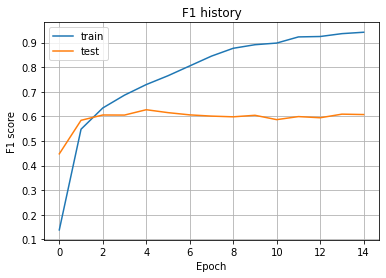

In [105]:
train_nn(epochs=15, learning_rate=0.001, embedding_dim=256, th=0.3, visual=True)

Но вообще мы видим, что достаточно быстро можем наблюдать переобучение модели.

## GRU

In [106]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [107]:
def train_nn_GRU(th=0.5, vocab_size=1500, embedding_dim=128, learning_rate=1e-3, epochs=epochs, batch_size=batch_size, visual=False):

  random_state = 42

  # max_words = 1500
  max_len = 15
  num_classes = 1

  # Training
  epochs = epochs
  batch_size = batch_size
  # embedding_dim = 256
  # out_channel = 256

  model_GRU = GRUFixedLen(vocab_size, embedding_dim)
  optimizer = torch.optim.Adam(model_GRU.parameters(), lr=learning_rate)
  criterion = nn.BCELoss()

  print("Parameters of model:", sum([param.nelement() for param in model_GRU.parameters()]))

  model_GRU = model_GRU.to(device)
  model_GRU.train()
  th = th

  train_loss_history = []
  test_loss_history = []
  train_f1_history = []
  test_f1_history = []

  for epoch in range(epochs):
  
    running_items, running_right = 0.0, 0.0
    tp, fp, tn, fn = 0, 0, 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_GRU(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

        tp += ((labels == 1) & (pred_labels == 1)).sum().item()
        tn += ((labels == 0) & (pred_labels == 0)).sum().item()
        fp += ((labels == 0) & (pred_labels == 1)).sum().item()
        fn += ((labels == 1) & (pred_labels == 0)).sum().item()

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    # выводим статистику о процессе обучения
    model_GRU.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          # f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}',
          f'F1-score: {f1_score:.3f}', end='. ')
    
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    tp, fp, tn, fn = 0, 0, 0, 0
    train_loss_history.append(loss)
    train_f1_history.append(f1_score)
    # print(train_f1_history)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    test_tp, test_fp, test_tn, test_fn = 0, 0, 0, 0

    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model_GRU(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))

        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

        test_tp += ((test_labels == 1) & (pred_test_labels == 1)).sum().item()
        test_tn += ((test_labels == 0) & (pred_test_labels == 0)).sum().item()
        test_fp += ((test_labels == 0) & (pred_test_labels == 1)).sum().item()
        test_fn += ((test_labels == 1) & (pred_test_labels == 0)).sum().item()

    test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) != 0 else 0
    test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) != 0 else 0

    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall) if (test_precision + test_recall) != 0 else 0
    
    test_loss_history.append(test_loss.item())
    test_f1_history.append(test_f1_score)
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}. Test F1_score: {test_f1_score:.3f}. Recall: {test_recall:.3f}')
    
    model_GRU.train()

  if visual is True:
   
    plt.title('F1 history')
    plt.grid(True)
    plt.ylabel('F1 score')
    plt.xlabel('Epoch')
    plt.plot(train_f1_history, label='train')
    plt.plot(test_f1_history, label='test')
    plt.legend();
        
  print('Training is finished!')

  return test_f1_history[-1]

In [116]:
f1_tab_gru = []
epch_tab_gru = []
lr_tab_gru = []
thr_tab_gru = []
emb_dim_tab_gru = []

for epch in n_epochs:
  for lr in learning_rates:
    for thr in ths:
      for e in e_dims:
        print('\033[1m' + f'Количество эпох: {epch} \nШаг обучения: {lr}' + '\033[0m')
        epch_tab_gru.append(epch)
        lr_tab_gru.append(lr)
        thr_tab_gru.append(thr)
        emb_dim_tab_gru.append(e)
        f1_tab_gru.append(round(train_nn_GRU(learning_rate=lr, epochs=epch, th=thr, embedding_dim=e), 3))
        print('-' * 50)
        print('\n')

Количество эпох: 10 
Шаг обучения: 0.01
Parameters of model: 390273
Epoch [1/10]. Loss: 0.139. Acc: 0.917 F1-score: 0.331. Test loss: 0.120. Test acc: 0.949. Test F1_score: 0.508. Recall: 0.377
Epoch [2/10]. Loss: 0.139. Acc: 0.949 F1-score: 0.609. Test loss: 0.113. Test acc: 0.944. Test F1_score: 0.594. Recall: 0.589
Epoch [3/10]. Loss: 0.106. Acc: 0.955 F1-score: 0.674. Test loss: 0.129. Test acc: 0.947. Test F1_score: 0.615. Recall: 0.605
Epoch [4/10]. Loss: 0.095. Acc: 0.961 F1-score: 0.718. Test loss: 0.125. Test acc: 0.941. Test F1_score: 0.596. Recall: 0.621
Epoch [5/10]. Loss: 0.090. Acc: 0.965 F1-score: 0.753. Test loss: 0.181. Test acc: 0.938. Test F1_score: 0.582. Recall: 0.621
Epoch [6/10]. Loss: 0.082. Acc: 0.969 F1-score: 0.781. Test loss: 0.171. Test acc: 0.940. Test F1_score: 0.598. Recall: 0.636
Epoch [7/10]. Loss: 0.050. Acc: 0.971 F1-score: 0.800. Test loss: 0.204. Test acc: 0.950. Test F1_score: 0.629. Recall: 0.603
Epoch [8/10]. Loss: 0.084. Acc: 0.975 F1-score: 0.

In [117]:
metrics_tab_GRU = pd.DataFrame({'epoch': epch_tab_gru,
                            'lr': lr_tab_gru, 'th': thr_tab_gru, 'emb_dim': emb_dim_tab_gru,
                            'test_f1_score': f1_tab_gru})
metrics_tab_GRU

,epoch,lr,th,emb_dim,test_f1_score
0,10,0.010,0.3,128,0.600
1,10,0.010,0.3,256,0.580
2,10,0.010,0.5,128,0.615
3,10,0.010,0.5,256,0.619
4,10,0.001,0.3,128,0.607
5,10,0.001,0.3,256,0.579
6,10,0.001,0.5,128,0.606
7,10,0.001,0.5,256,0.611
8,15,0.010,0.3,128,0.560
9,15,0.010,0.3,256,0.571


In [118]:
metrics_tab_GRU.loc[metrics_tab_GRU['test_f1_score'] == metrics_tab_GRU['test_f1_score'].max()]

,epoch,lr,th,emb_dim,test_f1_score
3,10,0.01,0.5,256,0.619


В отличии от LSTM шаг обучения потребовался больше, также порог срабатывания = 0.5

### Лучшая модель по GRU

Parameters of model: 631425
Epoch [1/10]. Loss: 0.135. Acc: 0.924 F1-score: 0.331. Test loss: 0.134. Test acc: 0.952. Test F1_score: 0.567. Recall: 0.449
Epoch [2/10]. Loss: 0.130. Acc: 0.957 F1-score: 0.622. Test loss: 0.075. Test acc: 0.954. Test F1_score: 0.581. Recall: 0.455
Epoch [3/10]. Loss: 0.100. Acc: 0.964 F1-score: 0.700. Test loss: 0.190. Test acc: 0.953. Test F1_score: 0.598. Recall: 0.496
Epoch [4/10]. Loss: 0.105. Acc: 0.969 F1-score: 0.752. Test loss: 0.146. Test acc: 0.950. Test F1_score: 0.619. Recall: 0.580
Epoch [5/10]. Loss: 0.068. Acc: 0.973 F1-score: 0.787. Test loss: 0.096. Test acc: 0.952. Test F1_score: 0.621. Recall: 0.560
Epoch [6/10]. Loss: 0.085. Acc: 0.976 F1-score: 0.820. Test loss: 0.131. Test acc: 0.952. Test F1_score: 0.606. Recall: 0.531
Epoch [7/10]. Loss: 0.053. Acc: 0.979 F1-score: 0.841. Test loss: 0.344. Test acc: 0.954. Test F1_score: 0.599. Recall: 0.491
Epoch [8/10]. Loss: 0.071. Acc: 0.981 F1-score: 0.856. Test loss: 0.099. Test acc: 0.950. 

0.6173410404624278

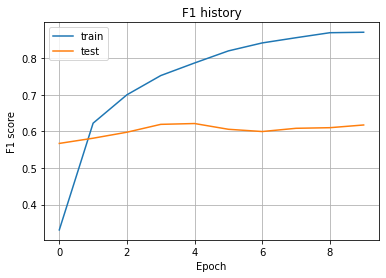

In [119]:
train_nn_GRU(epochs=10, learning_rate=0.01, embedding_dim=256, th=0.5, visual=True)

В целом мы также наблюдаем быстрое переобучение модели. Вероятно из-за малого количества обучающих примеров. Всё таки сильная несбалансированность классов влияет на результаты.

И в принципе, тесты запускались несколько раз для разных моделей и отличия были минимальны и в разных запусках разные параметры давали чуть лучшие результаты. Пожалуй чаще всего на GRU требовался шаг обучения больше, чем на LSTM. 

Всё таки низкая сложность задачи и несбалансированность классов не позволяют вообще найти сильных различий между обучением разными моделями. Даже одномерные свёртки дают очень близкий результат.

При этом по метрике Recall получилось добиться максимума на LSTM. И вообще рекурентные сети по этой метрике всё таки давали лучшие результаты, чем одномерные свёрточные сети.